In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
from scipy.ndimage import gaussian_filter
from scipy.spatial import KDTree
import scipy.ndimage as ndimage

In [9]:
def sample_nematic(kdtree, angles, grid_x, grid_y, num_points):
    order_field = np.zeros((len(grid_y), len(grid_x)), dtype=np.complex64)
    radius_used = np.zeros((len(grid_y), len(grid_x)))

    for ix in range(len(grid_x)):
        for iy in range(len(grid_y)):
            p = (grid_x[ix], grid_y[iy])
            distances, indices = kdtree.query(p, k=num_points)
            a = angles[indices]
            z = np.exp(2j*a)
            weights = np.exp(-distances**2/(np.mean(distances)**2))
            order_field[iy,ix] = np.inner(z, weights)/np.sum(weights)
            radius_used[iy,ix] = np.max(distances)

    return order_field, radius_used

def sample_nematic_adaptable(kdtree, angles, grid_x, grid_y, n_cutoff, r_cutoff):
    order_field = np.zeros((len(grid_y), len(grid_x)), dtype=np.complex64)
    neighbours = np.zeros((len(grid_y), len(grid_x)))
    radius_used = np.zeros((len(grid_y), len(grid_x)))

    for ix in range(len(grid_x)):
        for iy in range(len(grid_y)):
            p = (grid_x[ix], grid_y[iy])
            no_cells=False
            indices = kdtree.query_ball_point(p, r_cutoff)
            if len(indices)>n_cutoff:
                distances, indices = kdtree.query(p, k=np.int32(np.power(len(indices), 2/3)))
                radius_used[iy, ix] = np.max(distances)
            else: no_cells=True
            if not no_cells:
                a = angles[indices]
                z = np.exp(2j*a)
                weights = np.exp(-distances**2/(np.mean(distances)**2))
                order_field[iy,ix] = np.inner(z, weights)/np.sum(weights)   
                neighbours[iy, ix] = len(indices)

    return order_field, neighbours, radius_used

def sample_density(kdtree, grid_x, grid_y, num_points):
    densities = np.zeros((len(grid_y), len(grid_x)),dtype=np.float32)

    for ix in range(len(grid_x)):
        for iy in range(len(grid_y)):
            p = (grid_x[ix], grid_y[iy])
            distances, indices = kdtree.query(p, k=num_points)
            densities[iy,ix] = num_points/(np.pi*max(distances)**2)

    return densities

def sample_density_adaptable(kdtree, grid_x, grid_y,  n_cutoff, r_cutoff):
    densities = np.zeros((len(grid_y), len(grid_x)),dtype=np.float32)

    for ix in range(len(grid_x)):
        for iy in range(len(grid_y)):
            p = (grid_x[ix], grid_y[iy])
            no_cells=False
            indices = kdtree.query_ball_point(p, r_cutoff)
            if len(indices)>n_cutoff:
                k = np.int32(np.power(len(indices), 2/3))
                distances, indices = kdtree.query(p, k=k)
            else: no_cells=True
            if not no_cells:
                densities[iy,ix] = k/(np.pi*max(distances)**2)
    return densities

def filter_by_bounding_box(coordinates, x_min, x_max, y_min, y_max):
    coordinates = np.array(coordinates)
    in_box = (
        (coordinates[:, 0] >= x_min) & (coordinates[:, 0] <= x_max) &
        (coordinates[:, 1] >= y_min) & (coordinates[:, 1] <= y_max)
    )
    return in_box

In [5]:
exp=75
file_name='exp{:d}_merge_unique.csv'.format(exp)
data=np.genfromtxt('../Exp_data_Yimin/'+file_name, delimiter=',')[1:,:] #X, frame, xm, ym, major axis, minor axis, angle, track ID, posx, poxy
data[:, 6]*=np.pi/180

xlim=np.max(data[:,2])
ylim=np.max(data[:,3])
data[:, 3] = ylim - data[:, 3]

ncells=np.int32(data[-1,0])
print(xlim, ylim)

3709.403 3508.125


In [6]:
#find wehre new frames start. Gives you cell number and makes plotting easy
nframes = np.int32(data[-1, 1]+1)
framestart = np.zeros(nframes+1)

frames, framestart, nframecells = np.unique(data[:,1], return_counts=True, return_index=True)
nframes=frames[-1]+1

size=np.max(data[:,2:4], axis=0)

xlim=np.max(data[:,2])
ylim=np.max(data[:,3])

In [7]:
trees = []


for frame in np.arange(np.int32(nframes)):
    ncells=nframecells[frame]
    start=np.int32(framestart[frame])
    centers = data[start:start+ncells, 2:4]
    
    trees.append(KDTree(centers))

In [10]:
print(nframes)
grid_x = 10.0 * np.arange(10, xlim//10)
grid_y = 10.0 * np.arange(10, ylim//10)

order = []
orderadapt = []
densityadapt = []
kused = []
rused = []
rused_adapt =[]
density = []

for frame in np.arange(1, np.int32(nframes), 10):
    ncells=nframecells[frame]
    start=np.int32(framestart[frame])
    centers = data[start:start+ncells, 2:4]
    angles  = data[start:start+ncells, 6]

    mean_density = ncells/(xlim*ylim)

    num_pts = 10 # max k
    r_cutoff = 0.5 * np.sqrt(num_pts/(np.pi*mean_density))
    n_cutoff = 2

    tree =  trees[frame]

    orderadapt_, k_used_, r_used_ = sample_nematic_adaptable(tree, angles, grid_x, grid_y, n_cutoff, r_cutoff)
    orderadapt.append(orderadapt_); kused.append(k_used_); rused_adapt.append(r_used_)
    densityadapt.append(sample_density_adaptable(tree, grid_x, grid_y, n_cutoff, r_cutoff))
    order_, r_used_ = sample_nematic(tree, angles, grid_x, grid_y, num_pts)
    order.append(order_); rused.append(r_used_)
    density.append(sample_density(tree, grid_x, grid_y, num_pts))

order = np.array(order)
rused = np.array(rused)
density = np.array(density)
orderadapt = np.array(orderadapt)
densityadapt = np.array(densityadapt)
kused = np.array(kused)
rused_adapt = np.array(rused_adapt)

66.0


7.656421161352156 232.28281612077984


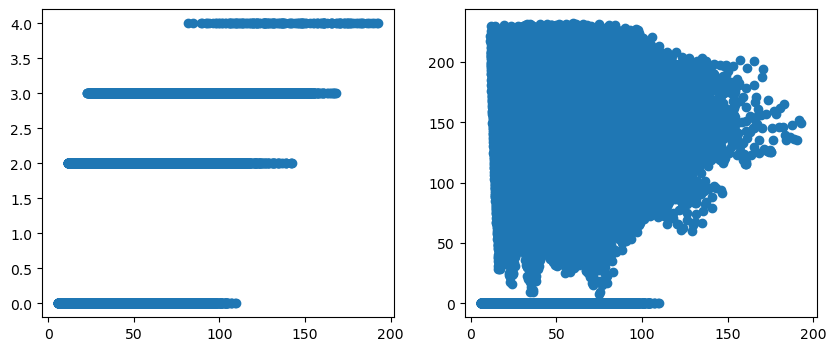

In [ ]:
frame=1
fig, ax = plt.subplots(figsize=(10,4), ncols=2, sharex=True)
s =1
ax[0].scatter(density[frame, ::s, ::s].flatten()*1e6/(0.585*0.585), kused[frame, ::s, ::s].flatten())
ax[1].scatter(density[frame, ::s, ::s].flatten()*1e6/(0.585*0.585), rused_adapt[frame, ::s, ::s].flatten())
print(np.min(rused_adapt[frame, rused_adapt[frame]>0]), np.max(rused_adapt[frame]))

In [64]:
box_sizes = []
densities = []

frame = 1
box_size_min = 2*np.min(rused_adapt[frame, rused_adapt[frame]>0])
box_size_max = 2*np.max(rused_adapt[frame])

box_sizes_frame = np.arange(box_size_min, box_size_max, 20)
box_sizes.append(box_sizes_frame)

for boxsize in box_sizes_frame:
    nocellsinbox=0
    fdata = np.copy(data[:, 6:]); fdata[:, -2:] = np.floor(fdata[:, -2:]/boxsize) # coordinates in box units
    ncells = nframecells[frame]
    start = np.int32(framestart[frame])
    framedata = fdata[start:start+ncells, :]

    nbox_x = np.int32(xlim/boxsize)
    nbox_y = np.int32(ylim/boxsize)
    nbox = nbox_x*nbox_y

    boxcells = np.zeros([nbox_x, nbox_y])

    for box in np.arange(nbox):
        boxcoords = np.array([box%nbox_x, box//nbox_x])
        cellsinbox = np.logical_and(framedata[:, -1] == boxcoords[1], framedata[:, -2] == boxcoords[0])
        boxdata = framedata[cellsinbox]
        boxcells[boxcoords[0], boxcoords[1]] = np.sum(cellsinbox)/boxsize**2

    densities.append(boxcells)

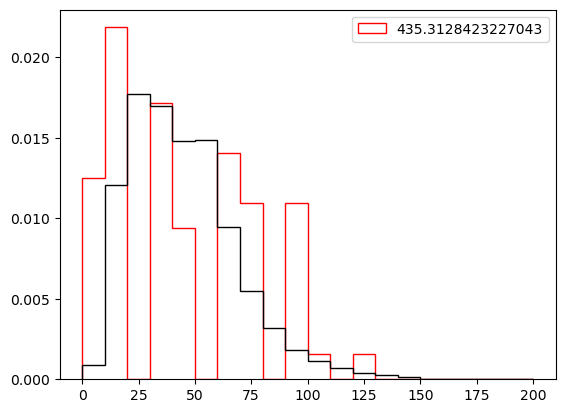

In [70]:
#for b in np.arange(1, len(box_sizes_frame), 2):
b=-2
plt.hist(densities[b].flatten()*1e6/(0.585*0.585), bins=20, histtype='step', range=(0, 200), density=True, label=box_sizes_frame[b], color=plt.cm.hsv(b/len(box_sizes_frame)))
plt.hist(density[frame].flatten()*1e6/(0.585*0.585), bins=20, histtype='step', range=(0, 200), density=True, color='k')
plt.legend()
plt.show()

In [129]:

frame = 1
box_size = 450
sweep_size = 10
box_points_x = np.arange(box_size/2, xlim-box_size/2, sweep_size)
box_points_y = np.arange(box_size/2, ylim-box_size/2, sweep_size)
box_points = np.meshgrid(box_points_x, box_points_y, indexing='ij')
nbox_x = len(box_points_x)
nbox_y = len(box_points_y)
nbox = nbox_x * nbox_y
densities = np.zeros((len(box_points_x), len(box_points_y)))

for box in np.arange(nbox):

    nocellsinbox=0
    box_center_x = box_points[0] [box%nbox_x][box//nbox_x]
    box_center_y = box_points[1] [box%nbox_x][box//nbox_x]
    box_center = np.vstack((box_center_x, box_center_y)).T

    fdata = np.copy(data[:, -2:])
    fdata -= box_center
    fdata = np.floor(fdata[:, -2:]/box_size) # coordinates in box units
    
    ncells = nframecells[frame]
    start = np.int32(framestart[frame])
    framedata = fdata[start:start+ncells, :]

    cellsinbox = np.logical_and(framedata[:, -1] == 0, framedata[:, -2] == 0)

    densities[box%nbox_x, box//nbox_x] = np.sum(cellsinbox)/box_size**2

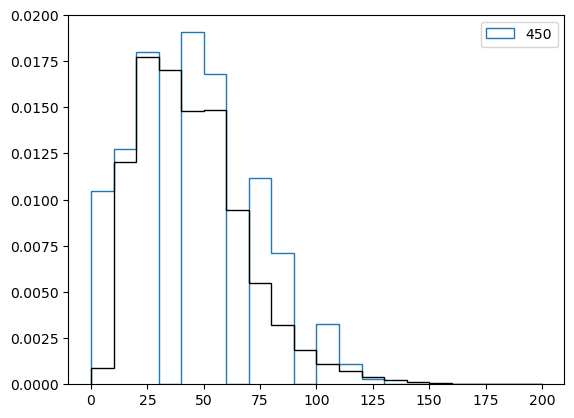

In [130]:
plt.hist(densities.flatten()*1e6/(0.585*0.585), bins=20, histtype='step', range=(0, 200), density=True, label=box_size)
plt.hist(density[frame].flatten()*1e6/(0.585*0.585), bins=20, histtype='step', range=(0, 200), density=True, color='k')
plt.legend()
plt.show()